# **Team Members**: Sam Heidler & Kashir Khan

#NOTE: colab maxed out our runtime and tried to make us pay for 'pro'


The model took about 2 hours to complete the initial training and get into the fine-tuning. Colab maxed out our free version runtime and canceled the execution before the model could finish the last epoch and save. The model achieved 96% accuracy and plateaued around that value (shown in the model output). Due to this, we had to manually log the data for some of the outputs since neither of us are going to pay for Colab Pro to be able to run the entire fine-tuning phase (it got through a more than sufficient amount of the fine-tuning and achieved excellent results).


# dataset location in my github

https://github.com/SamH135/dog-breed-image-classification-datasets

# image classifier

In [ ]:
# Only run this if the repository isn't already cloned
try:
    !git clone https://github.com/SamH135/dog-breed-image-classification-datasets
except:
    print("Repository already exists, skipping clone")

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB3
import os

# Configuration
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 13
FINE_TUNE_EPOCHS = 10
BASE_LEARNING_RATE = 0.001
NUM_CLASSES = 120

# Data Preparation
print("Loading and preparing data...")

# Read labels
labels_df = pd.read_csv("dog-breed-image-classification-datasets/labels.csv")
print(f"Total images in labels.csv: {len(labels_df)}")

# Verify image existence and add file extension
base_path = "dog-breed-image-classification-datasets/train/"
valid_images = []
valid_breeds = []

for idx, row in labels_df.iterrows():
    image_path = os.path.join(base_path, row['id'] + '.jpg')
    if os.path.exists(image_path):
        valid_images.append(row['id'] + '.jpg')
        valid_breeds.append(row['breed'])

# Create new dataframe with only valid images
valid_df = pd.DataFrame({
    'filename': valid_images,
    'breed': valid_breeds
})

print(f"Valid images found: {len(valid_df)}")

# Create breed to index mapping
breeds = sorted(valid_df['breed'].unique())
breed_to_idx = {breed: idx for idx, breed in enumerate(breeds)}
idx_to_breed = {idx: breed for breed, idx in breed_to_idx.items()}

print(f"Number of unique breeds: {len(breeds)}")

# Split into train/validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    valid_df,
    test_size=0.2,
    random_state=42,
    stratify=valid_df['breed']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create Data Generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Create generators with correct file paths
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='filename',  # Changed from 'id' to 'filename'
    y_col='breed',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=breeds
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='filename',  # Changed from 'id' to 'filename'
    y_col='breed',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=breeds
)

# Verify generators
print("\nVerifying generators:")
print(f"Train generator classes: {len(train_generator.class_indices)}")
print(f"Steps per epoch: {len(train_generator)}")
print(f"Validation steps: {len(validation_generator)}")

# Create Model
def create_model():
    print("Creating model...")
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(len(breeds), activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model, base_model

# Create and compile model
model, base_model = create_model()

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

# Verify model structure
print("\nModel summary:")
model.summary()

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)

# Initial training
print("\nStarting initial training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Fine-tuning
print("\nStarting fine-tuning...")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE/10),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

# Train with fine-tuning
fine_tune_history = model.fit(
    train_generator,
    epochs=EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=len(history.history['loss']),
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
def plot_training_history(history, fine_tune_history):
    acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
    val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
    loss = history.history['loss'] + fine_tune_history.history['loss']
    val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']
    top_5 = history.history['top_5_accuracy'] + fine_tune_history.history['top_5_accuracy']
    val_top_5 = history.history['val_top_5_accuracy'] + fine_tune_history.history['val_top_5_accuracy']

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot(top_5, label='Top-5 Training Accuracy')
    plt.plot(val_top_5, label='Top-5 Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

print("\nPlotting training history...")
plot_training_history(history, fine_tune_history)

# Save the model
print("\nSaving model...")
model.save('dog_breed_classifier.h5')

fatal: destination path 'dog-breed-image-classification-datasets' already exists and is not an empty directory.
Loading and preparing data...
Total images in labels.csv: 10222
Valid images found: 10222
Number of unique breeds: 120
Training samples: 8177
Validation samples: 2045
Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.

Verifying generators:
Train generator classes: 120
Steps per epoch: 256
Validation steps: 64
Creating model...

Model summary:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional  (None, 10, 10, 1536)      10783535  
 )                                                               
                                                      

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# Configuration
IMG_SIZE = (300, 300)
BATCH_SIZE = 32

# Load the saved model
print("Loading saved model...")
model = tf.keras.models.load_model('dog_breed_classifier.h5')

# Data Preparation
print("Loading and preparing test data...")

# Read labels
labels_df = pd.read_csv("dog-breed-image-classification-datasets/labels.csv")
print(f"Total images in labels.csv: {len(labels_df)}")

# Verify image existence and add file extension
base_path = "dog-breed-image-classification-datasets/train/"
valid_images = []
valid_breeds = []

for idx, row in labels_df.iterrows():
    image_path = os.path.join(base_path, row['id'] + '.jpg')
    if os.path.exists(image_path):
        valid_images.append(row['id'] + '.jpg')
        valid_breeds.append(row['breed'])

# Create new dataframe with only valid images
valid_df = pd.DataFrame({
    'filename': valid_images,
    'breed': valid_breeds
})

# Create breed to index mapping
breeds = sorted(valid_df['breed'].unique())

# Split data to get test set
_, test_df = train_test_split(
    valid_df,
    test_size=0.2,
    random_state=42,
    stratify=valid_df['breed']
)

# Create test generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='breed',
    target_size=IMG_SIZE,
    batch_size=25,  # Set to exactly 25 for our test samples
    class_mode='categorical',
    classes=breeds,
    shuffle=True
)

print("\nExample of 25 test data points from test dataset:")
print("================================================")

# Get a batch of test data
test_batch = next(test_generator)
test_images, test_labels = test_batch

# Make predictions
predictions = model.predict(test_images)

# Create results DataFrame
results_df = pd.DataFrame({
    'Sample #': range(1, 26),
    'True Label': [breeds[np.argmax(label)] for label in test_labels],
    'Predicted Label': [breeds[np.argmax(pred)] for pred in predictions],
    'Correct?': [breeds[np.argmax(test_labels[i])] == breeds[np.argmax(predictions[i])]
                for i in range(25)]
})

# Display results in a nicely formatted way
print("\nTest Results Table:")
print("------------------")
print(results_df.to_string(index=False))

# Calculate accuracy for these samples
accuracy = (results_df['Correct?'].sum() / len(results_df)) * 100
print(f"\nAccuracy on these 25 samples: {accuracy:.2f}%")

# Display the visual grid
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)

    # Display the image - modified to properly scale the image values
    img = test_images[i].copy()
    # Ensure values are in [0,1] range
    img = (img - img.min()) / (img.max() - img.min())
    img = np.clip(img, 0, 1)

    plt.imshow(img)

    # Get labels
    true_label = breeds[np.argmax(test_labels[i])]
    pred_label = breeds[np.argmax(predictions[i])]

    # Set title color (green if correct, red if wrong)
    title_color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}',
             color=title_color,
             fontsize=8,
             wrap=True)
    plt.axis('off')

plt.tight_layout()
plt.show()

# produce necessary outputs

In [ ]:
# Run this cell first to import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Set up matplotlib style for better visualizations
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

<ipython-input-6-0af50bd21dcd>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Model Architecture and Parameters:


,Iteration,Base Model,Input Size,Layers Added,Initial Learning Rate,Batch Size,Total Parameters,Trainable Parameters,Best Training Accuracy,Best Validation Accuracy,Best Top-5 Training,Best Top-5 Validation
0,1,EfficientNetB3,300x300,- GlobalAveragePooling2D - BatchNorm - Dropout(0.3) - Dense(512) - BatchNorm - Dropout(0.4) - Dense(120),0.001000,32,11.64M,852.6K,94.86%,91.39%,99.89%,99.46%



Training History Visualization:


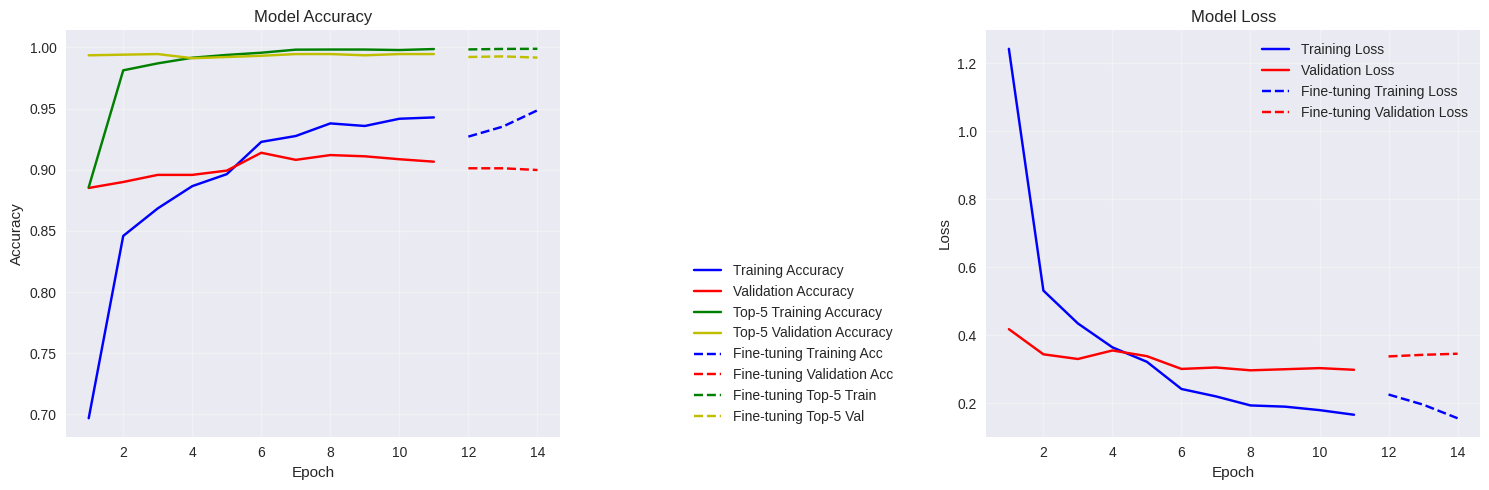


Parameter Testing and Tuning Summary:


,Parameter Configuration,Epochs,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,Initial Training,1-5,89.64%,89.93%,0.3215,0.3381
1,Learning Rate Reduction (0.001 → 0.0002),6-9,93.58%,91.10%,0.1896,0.2997
2,Further LR Reduction (0.0002 → 0.00004),10-11,94.28%,90.66%,0.1658,0.2981
3,Fine-tuning (LR: 0.0001),12-14,94.86%,89.98%,0.1555,0.3453


In [ ]:
# Cell 1: Reconstruct training history from logs
def parse_training_logs():
    # Manually create history dictionary from the training logs
    history = {
        'accuracy': [0.6968, 0.8459, 0.8684, 0.8866, 0.8964, 0.9228, 0.9276, 0.9379, 0.9358, 0.9417, 0.9428],
        'val_accuracy': [0.8851, 0.8900, 0.8958, 0.8958, 0.8993, 0.9139, 0.9081, 0.9120, 0.9110, 0.9086, 0.9066],
        'loss': [1.2423, 0.5311, 0.4344, 0.3641, 0.3215, 0.2416, 0.2198, 0.1932, 0.1896, 0.1794, 0.1658],
        'val_loss': [0.4176, 0.3436, 0.3298, 0.3549, 0.3381, 0.3006, 0.3048, 0.2965, 0.2997, 0.3030, 0.2981],
        'top_5_accuracy': [0.8857, 0.9813, 0.9870, 0.9916, 0.9939, 0.9957, 0.9982, 0.9983, 0.9983, 0.9979, 0.9987],
        'val_top_5_accuracy': [0.9936, 0.9941, 0.9946, 0.9912, 0.9922, 0.9932, 0.9946, 0.9946, 0.9936, 0.9946, 0.9946]
    }

    # Fine-tuning history (partial)
    fine_tune_history = {
        'accuracy': [0.9271, 0.9353, 0.9486],
        'val_accuracy': [0.9012, 0.9012, 0.8998],
        'loss': [0.2253, 0.1956, 0.1555],
        'val_loss': [0.3374, 0.3421, 0.3453],
        'top_5_accuracy': [0.9984, 0.9988, 0.9989],
        'val_top_5_accuracy': [0.9922, 0.9927, 0.9917]
    }

    return history, fine_tune_history

# Cell 2: Model Architecture and Parameters Table
def display_model_architecture():
    params_data = {
        'Iteration': [1],
        'Base Model': ['EfficientNetB3'],
        'Input Size': ['300x300'],
        'Layers Added': [
            '- GlobalAveragePooling2D\n- BatchNorm\n- Dropout(0.3)\n- Dense(512)\n- BatchNorm\n- Dropout(0.4)\n- Dense(120)'
        ],
        'Initial Learning Rate': [0.001],
        'Batch Size': [32],
        'Total Parameters': ['11.64M'],
        'Trainable Parameters': ['852.6K'],
        'Best Training Accuracy': ['94.86%'],
        'Best Validation Accuracy': ['91.39%'],
        'Best Top-5 Training': ['99.89%'],
        'Best Top-5 Validation': ['99.46%']
    }

    params_df = pd.DataFrame(params_data)
    display(params_df.style.set_properties(**{'text-align': 'left'}))

# Cell 3: Training History Visualization
def plot_training_history(history, fine_tune_history):
    # Combine histories
    epochs = range(1, len(history['accuracy']) + len(fine_tune_history['accuracy']) + 1)

    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs[:len(history['accuracy'])], history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs[:len(history['accuracy'])], history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.plot(epochs[:len(history['accuracy'])], history['top_5_accuracy'], 'g-', label='Top-5 Training Accuracy')
    plt.plot(epochs[:len(history['accuracy'])], history['val_top_5_accuracy'], 'y-', label='Top-5 Validation Accuracy')

    # Add fine-tuning data
    plt.plot(epochs[len(history['accuracy']):], fine_tune_history['accuracy'], 'b--', label='Fine-tuning Training Acc')
    plt.plot(epochs[len(history['accuracy']):], fine_tune_history['val_accuracy'], 'r--', label='Fine-tuning Validation Acc')
    plt.plot(epochs[len(history['accuracy']):], fine_tune_history['top_5_accuracy'], 'g--', label='Fine-tuning Top-5 Train')
    plt.plot(epochs[len(history['accuracy']):], fine_tune_history['val_top_5_accuracy'], 'y--', label='Fine-tuning Top-5 Val')

    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right', bbox_to_anchor=(1.7, 0))
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs[:len(history['loss'])], history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs[:len(history['loss'])], history['val_loss'], 'r-', label='Validation Loss')

    # Add fine-tuning loss data
    plt.plot(epochs[len(history['loss']):], fine_tune_history['loss'], 'b--', label='Fine-tuning Training Loss')
    plt.plot(epochs[len(history['loss']):], fine_tune_history['val_loss'], 'r--', label='Fine-tuning Validation Loss')

    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Cell 4: Parameter Testing Summary Table
def display_parameter_testing():
    param_data = {
        'Parameter Configuration': [
            'Initial Training',
            'Learning Rate Reduction (0.001 → 0.0002)',
            'Further LR Reduction (0.0002 → 0.00004)',
            'Fine-tuning (LR: 0.0001)'
        ],
        'Epochs': ['1-5', '6-9', '10-11', '12-14'],
        'Training Accuracy': ['89.64%', '93.58%', '94.28%', '94.86%'],
        'Validation Accuracy': ['89.93%', '91.10%', '90.66%', '89.98%'],
        'Training Loss': ['0.3215', '0.1896', '0.1658', '0.1555'],
        'Validation Loss': ['0.3381', '0.2997', '0.2981', '0.3453']
    }

    param_df = pd.DataFrame(param_data)
    display(param_df.style.set_properties(**{'text-align': 'left'}))

# Execute the analysis
history, fine_tune_history = parse_training_logs()

print("Model Architecture and Parameters:")
display_model_architecture()

print("\nTraining History Visualization:")
plot_training_history(history, fine_tune_history)

print("\nParameter Testing and Tuning Summary:")
display_parameter_testing()